# Lecture 5 - Survival Analysis

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Identify when data is censored.
- Understand the consequence of subsetting to uncensored data or ignoring the censored property instead of using Survival Analysis methods.
- Obtain univariate estimates for the mean, median, and survival function in `R` with the Kaplan-Meier technique.
- Identify when the Kaplan-Meier survival function estimate cannot produce mean and high quantile estimates.
- Interpret the regression coefficients of a Cox Proportional Hazards model, and identify the model assumptions.
- Obtain predictions from a Cox Proportional Hazards model.

## Loading Libraries

In [1]:
options(repr.matrix.max.rows = 6)
library(tidyverse)
library(broom)
library(ggfortify)
library(survival)
library(survminer)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


The following object is masked from ‘package:lubridate’:

    stamp




## 0. What have we covered so far?

In terms of a **conditioned mean response on its respective regressors**, the classical ordinary least-squares (OLS) model is not enough when we encounter the following:

- Restricted continuous response range.
- **Discrete responses.**

Discrete responses need a different approach, i.e., **generalized linear models (GLMs)** via different **link functions** as follows:

- **Binary Logistic regression** for binary responses.
- **Poisson** or **Negative Binominal** regressions for count responses.
- **Multinomial Logistic regression** for categorical and nominal responses.
- **Ordinal Logistic regression** for categorical and ordinal responses.

Furthermore, we can extend the OLS and GLM approaches to a **mixed-effects** framework. Therefore, we will be able to incorporate **complex correlated data structures** in our training sets.

However, what happens when we encounter **censored data** in a continuous response framework (i.e., it is not possible to record some event of interest when we finish our observational study/experiment for some subjects)?

``` {figure} ../img/panda.png
:height: 350px
:name: panda-lec5
The Questioning Panda is here, again.
```

Having said all this, let us dig into this new class of data we have not seen so far. Regarding Regression Analysis, modelling survival times will take us to two statistical approaches: **parametric** and **semiparametric**.

````{div} full-width
```{figure} ../img/reg-mindmap-5.png
:height: 750px
:name: reg-mindmap-5
Expanded regression modelling mind map (click on the image to expand).
```
````

## 1. Time to Event and Censoring

Suppose that we want to analyze **the time until an event occurs**. For example:

- The time until some equipment breaks.
- The time that unemployed people will take to land a new job.

```{important} 
Although this field in Statistics is usually referred to as **Survival Analysis**, the event in question does not need to be related to actual "*survival*", like the unemployed example.

The important thing is to understand that we are interested in **the time until something happens**.
```

```{exercise}
:label: lecture5-q1

Nevertheless, why is this different? Cannot we just use the techniques we have learned so far (e.g., a Binary Logistic regression model)?
```

Now, what are the implications of **not taking into account censoring in data**?

- Removing censored data will result in **estimation uncertainty to be larger than it could be if we were to include the censored data**. Under a frequentist approach, we would lose data points which will decrease the precision of our estimates.
- Removing censored data could also result in **biased estimates** if data have only been collected for a short time. These biased estimates would be obtained from those observations where the event of interest actually happened.

## 2. Censoring Examples

### 2.1. Constant Right-Censoring

Suppose we want to study **the time until patients with a specific type of cancer die**. The study will be funded for ten years, i.e., **after the 10th year, the study will end**. So, we will only observe the exact time some patients died within ten years. If an individual did not die due to cancer at the end of the study, then **all we know is that the time of occurrence for that individual is higher than ten years**. We do not know the exact time that person will die from cancer.

```{figure} ../img/survival_study.png
:height: 350px
:name: survival_study_1
Right-censoring diagram.
```

### 2.2. Random Right-Censoring

We can have other types of censoring as well. Using the previous example, if a patient were hit by a bus and died in the accident, the death would be unrelated to cancer. Hence, **all we know is that the patient did not die due to cancer until that moment**.

Or, **in a less "dark" example**, what if a patient you were following moves out of the country? It is an analogous situation. All we know is that the patient was alive until they moved.

```{admonition} What is the Difference Between Constant and Random Right-Censoring?
The most significant difference is that we could have a single and **constant** censoring time point (as shown in the blue vertical line in {numref}`survival_study_1` on the right-hand side), or a non-defined **random** censoring time point (as in the example of the bus accident or the patient's moving).

However, **as long as the censoring is independent of the time of the event of interest**, we can deal with both situations quite similarly.
```

There are other types of censoring besides right-censoring, but right-censoring is the most common one, and it will be the focus of this lecture. However, let us check an example of **left-censoring**.

### 2.3. Left-Censoring

**Suppose you want to know when kids learn how to ski.** One of the kids participating in your study already knows how to ski. So, **the event already happened in a past time, but you cannot know precisely when it was**. All you know is that it was before the current time. 

## 3. Key Concepts

We learned in **DSCI 551** that a random variable is characterized by its **probability distribution** (either density if continuous, or mass if discrete). In **Survival Analysis**, however, we frequently do not try to model the distribution directly. Instead, the focus is on modelling the **survival** or **hazard functions**.

These two functions are quite crucial in Survival Analysis because they have special interpretations. **If we know either of them, we can obtain the probability distribution for the time until an event occurs.** They are just alternative ways to represent a probability distribution

### 3.1. Survival Function

Let us start with some definitions

```{admonition} Definition of Survival Function
:class: tip
For this function, let us consider a **continuous** random variable 

$$Y = \text{Time until an event occurs.}$$

We know that the cumulative distribution function (CDF) of $Y$ tells us the probability that the event of interest occurs **before a certain point in time $t$**:

$$
F_Y(t) = P(Y \leq t).
$$

However, as the name suggests, in Survival Analysis, we are more interested in the probability that the event **WILL NOT** occur before a certain point in time $t$ (i.e., **the subject survives at least at point $t$**):

$$
S_Y(t) = P(Y > t) = 1 - F_Y(t).
$$

$S_Y(t)$ is called the **survival function**.
```

#### 3.1.1. Example

Suppose that $Y$ is being measured in `days`. So, we can measure the probability that the event of interest will not occur before $t = 10$ days by

$$
S_Y(10) = P(Y > 10) = 1 - F_Y(10).
$$

```{figure} ../img/survival_function.png
:height: 400px
:name: survival-study-2

Example of survival function (from [Kleinbaum and Klein, 2005](https://gw2jh3xr2c.search.serialssolutions.com/?sid=sersol&SS_jc=TC0000320278&title=Survival%20analysis%20%3A%20a%20self-learning%20text)).
```

Furthermore, as we can see in {numref}`survival-study-2`, note that any survival function (measured as a probability on the $y$-axis with time on the $x$-axis) **WILL ALWAYS be monotonically decreasing as time goes by**. This behaviour is expected in any subject since their survival chances would decrease over time.

#### 3.1.2. Is the Survival Function Enough?

Note that the survival function $S_Y(t)$ fully characterizes $Y$. In other words, **if we know the survival function, we have everything we need about $Y$**.

For instance, we can get the CDF $F_Y(t)$ directly from the survival function:

$$
F_Y(t) = 1 - S_Y(t).
$$

We could also get the probability density function (PDF) $f_Y(t)$ directly from the survival function **by taking the negative derivative of $S_Y(t)$ with respect to the time $t$ before the event occurs**:

```{math}
\begin{align*}
f_Y(t) &= \frac{dF_Y(t)}{dt} \\
&= -\frac{dS_Y(t)}{dt}.
\end{align*}
```

### 3.2. Hazard Function

It is essential to remark that this function is particularly important for one of our subsequent regression models.

```{admonition} Definition of Hazard Function
:class: tip
Let us consider a **continuous** random variable

$$Y = \text{Time until an event occurs.}$$

Their survival and PDF functions are $S_Y(t)$ and $f_Y(t)$. That said, the hazard function $\lambda(t)$, the **instantaneous rate of event occurrence per unit of time**, is given by

$$
\lambda(t) = \lim_{\Delta t\rightarrow 0} \frac{P(t\leq Y < t+\Delta t | Y\geq t)}{\Delta t} = \frac{f_Y(t)}{S_Y(t)}.
$$

One can interpret $\lambda(t)\Delta t$ as the approximate probability of the event occurring immediately, given that the event has not occurred up until time $t$.
```

#### 3.2.1. Example

Since we know how to calculate the survival function $S_Y(t)$ from the cumulative distribution $F_Y(t)$, we can obtain the survival function for **any positive random variable**.

```{admonition} Why positive?
Because it measures the time until the event happens.
```

Let us check an example of the Weibull distribution case to model $S_Y(t)$.

#### 3.2.2. The Weibull Case

The Weibull distribution is one of the most popular **parametric** modelling choices in Survival Analysis to model $S_Y(t)$. Retaking **DSCI 551** concepts, this is a **heavy-tailed continuous distribution**.

Let 

$$Y \sim \text{Weibull}(\alpha, \beta).$$

Its PDF is given by:

$$
f_Y(t) = \frac{\alpha}{\beta^\alpha}t^{\alpha - 1}\exp\left[-\left(\frac{t}{\beta}\right)^{\alpha}\right] \quad \text{for} \quad t, \alpha, \beta > 0;
$$

where $\alpha$ is called the **shape parameter** and $\beta$ is the **scale parameter**.

Note that if $\alpha = 1$ we get the exponential distribution with parameter $\beta$.

```{important} 
Let us recall that a heavy-tailed distribution assigns a larger probability density to extreme values, which aligns with time to events of interest in Survival Analysis.
```

```{attention}
Generally speaking, the terms **shape** and **scale** along with **location**, are broadly used in statistical distributions for the following:

- **Location:** A parameter of this class shifts the distribution of interest to the left or right of the $x$-axis. For instance, in the Normal distribution, the mean $\mu$ is a location parameter that will shift the peak to that value $\mu$ on the $x$-axis.
- **Scale:** A parameter of this class stretches out (if it is large) of squeezes (if it is small) the distribution of interest. For example, with the Normal distribution, the standard deviation $\sigma$ is a scale parameter. Recall that, as we decrease $\sigma$, the bell-shape gets narrower and narrower. On the other hand, we see the opposite when we increase $\sigma$: the bell-shape gets wider and wider. For the Weibull case, in the plot below, we can see that a smaller value of the scale parameter $\beta$ squeezes to curve, leading it to be closer to the $y$-axis.
- **Shape:** This parameter is more tricky to define since it affects the form of the distribution rather than just stretching out or squeezing. For the Weibull case, in the plot below, **a larger shape parameter makes the function more concave** (check the green curve), whereas **a smaller shape parameter makes the function more convex** (check the purple curve).
```

Weibull's CDF is given by

$$
F_Y(t) = 1 - \exp\left[-\left(\frac{t}{\beta}\right)^{\alpha}\right] \quad \text{for} \quad t > 0.
$$

Therefore, the survival function of the Weibull distribution is:

$$
S_Y(t) = \exp\left[-\left(\frac{t}{\beta}\right)^{\alpha}\right] \quad \text{for} \quad t > 0.
$$

Now let us check how the survival function behaves under different scale and shape parameters.

In [2]:
options(repr.plot.height = 9, repr.plot.width = 20)

weibull_param <- tibble(shape = c(0.5, 1, 2, 3), scale = c(5, 1, 2, 3))

weibull_data <- tibble(t = seq(0.01, 5, 0.01)) %>%
  merge(weibull_param) %>%
  mutate(surv = exp(-(t / scale)^shape))

weibull_plot <- weibull_data %>%
  ggplot(aes(t, surv, color = interaction(shape, scale))) +
  ggtitle("Examples of Weibull's Survival Functions") +
  labs(x = "Time (Years)", y = "Survival Probability") +
  annotate("text", x = 1.5, y = 0.93, label = "Type A", size = 8, angle = -35) +
  annotate("text", x = 1, y = 0.84, label = "Type B", size = 8, angle = -50) +
  annotate("text", x = 3.5, y = 0.47, label = "Type C", size = 8, angle = -10) +
  annotate("text", x = 1.2, y = 0.37, label = "Type D", size = 8, angle = -50) +
  geom_line() +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 21, margin = margin(r = 1, unit = "cm")), 
    legend.title = element_text(size = 21, face = "bold")
  ) +
  scale_color_manual(values = c("blue", "red", "green", "purple"), 
                     labels = c("1, 1", "2, 2", "3, 3", "0.5, 5")) +
  guides(color = guide_legend(title = "Shape and Scale Parameters"))

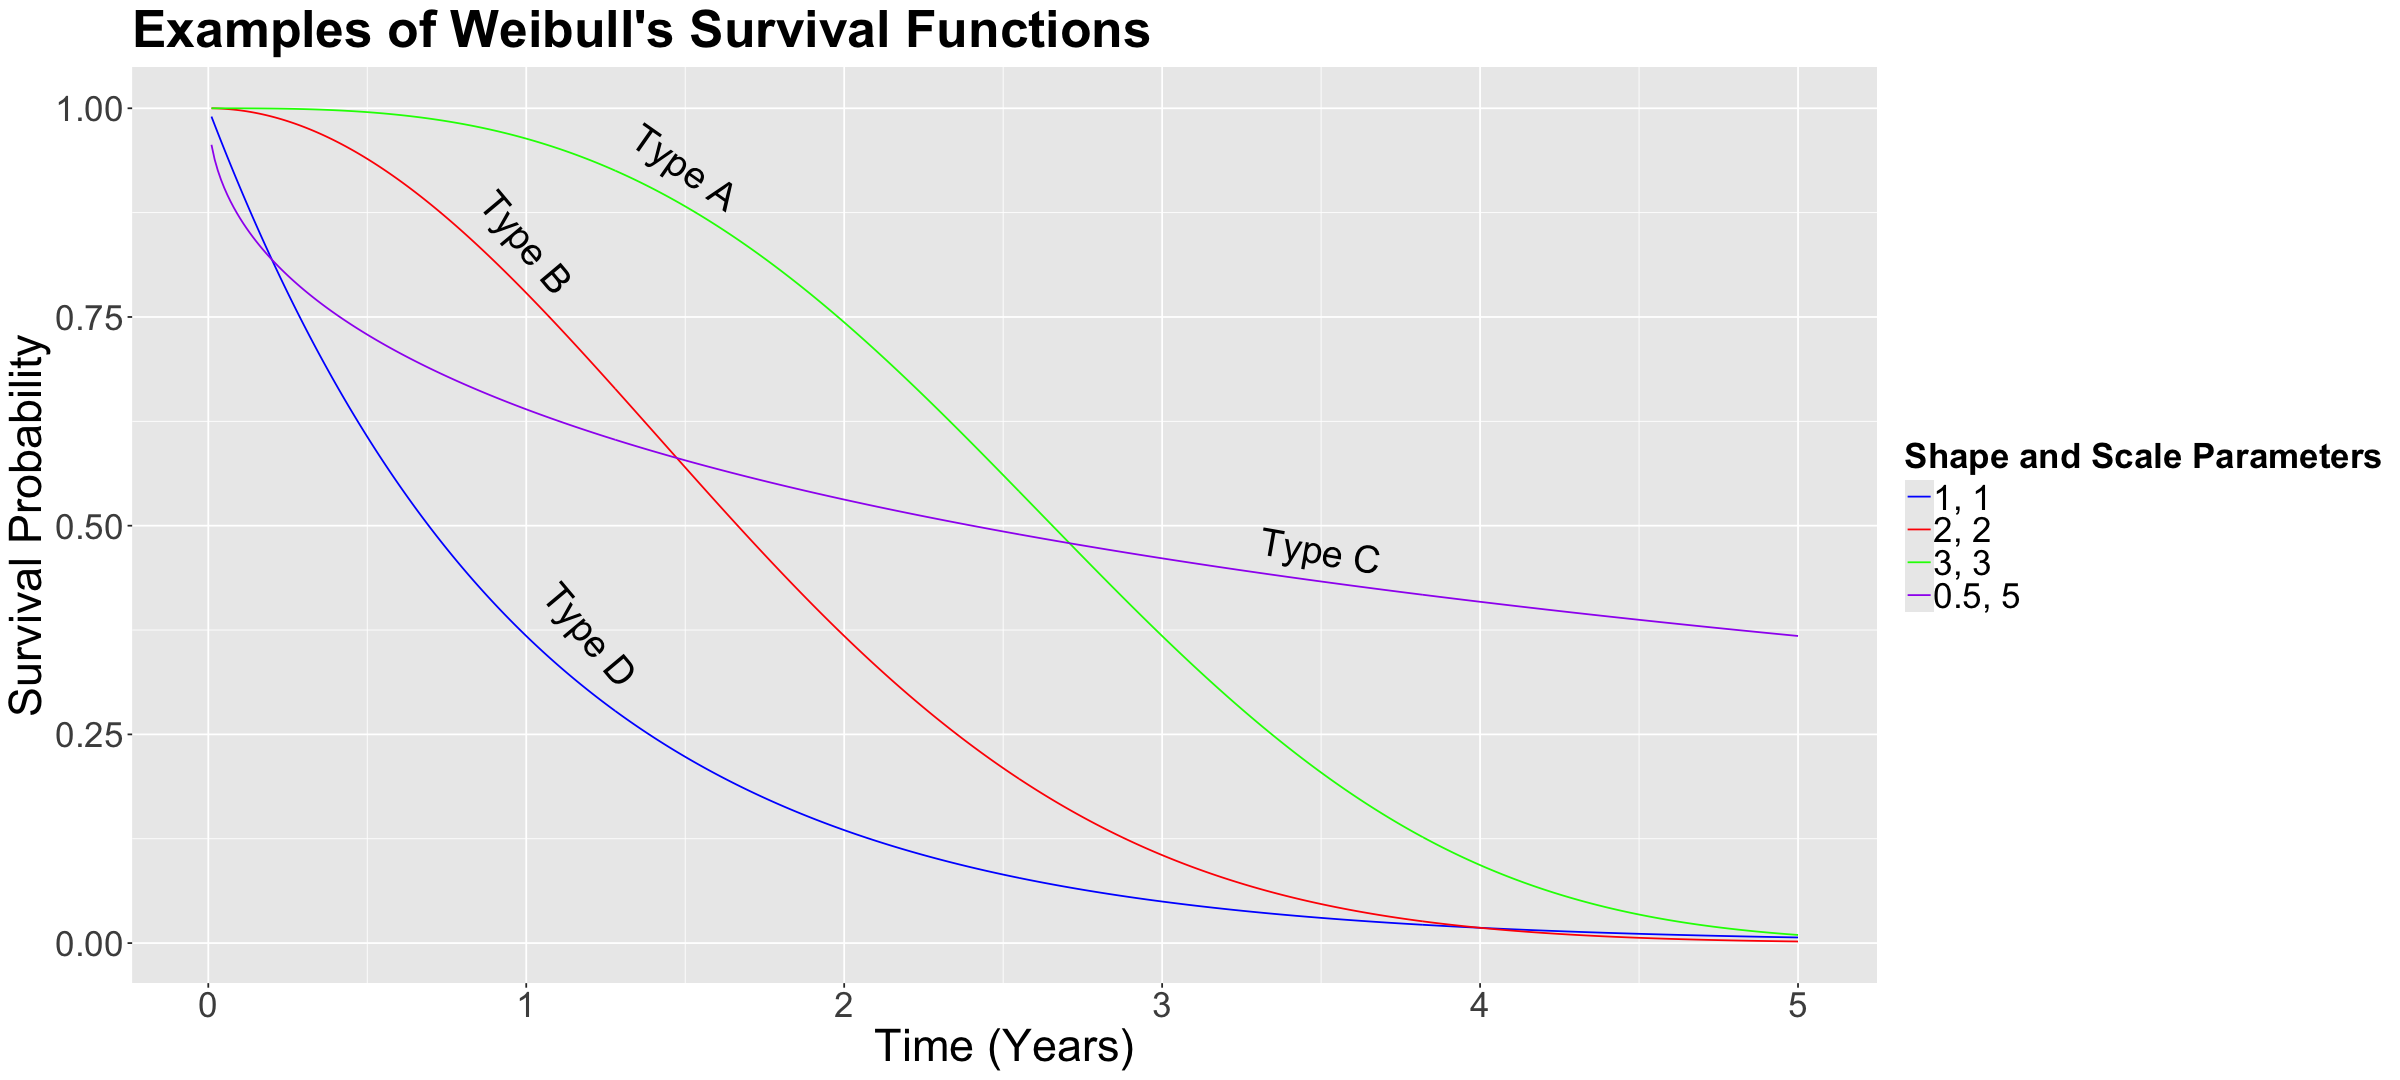

In [3]:
weibull_plot

```{exercise}
:label: lecture5-q2

Suppose that the previous curves are the survival functions of cancer patients for different types of cancer. Interpret the *Type D* in comparison to the *Type A*.

**A.** *Type A* is a more agressive type of cancer than *Type D*.

**B.** Both types of cancer are equally agressive.

**C.** *Type D* is a more agressive type of cancer than *Type A*.
```

Note that we can use `pweibull()` in `R` to get the survival probability of each time $t$. For the *Type D* (blue) cancer at year 2, the probability is obtained as follows:

In [4]:
round(pweibull(q = 2, shape = 1, scale = 1, lower.tail = FALSE), 2)

[1] 0.14

Now, the hazard function for the Weibull distribution is given by:

```{math}
:label: hazard-weibull
\lambda(t) = \frac{f_Y(t)}{S_Y(t)} = \frac{\alpha}{\beta^\alpha}t^{\alpha - 1}.
```

```{exercise}
:label: lecture5-q3

In the hazard function {eq}`hazard-weibull`, what happens if $\alpha = 1$?

**A.** The Weibull's hazard function increases over time.

**B.** The Weibull's hazard function is constant (does not depend on the time).

**C.** The Weibull's hazard function decreases over time.
```

Now, let us compare Weibull hazard functions with different values for $\alpha$ and $\beta$ for each type of cancer. Firstly, in general, we know that the Weibull hazard function is the following:

```{math}
\lambda(t) = \frac{f_Y(t)}{S_Y(t)} = \frac{\alpha}{\beta^\alpha}t^{\alpha - 1}.
```

- For *Type A*, the hazard function is the following:

```{math}
\begin{align*}
\lambda_A\left(t \mid \alpha = 3, \beta = 3 \right) &= \frac{3}{3^3}t^{3 - 1} \\
& = \frac{t^2}{9}.
\end{align*}
```

- For *Type B*, the hazard function is the following:

```{math}
\begin{align*}
\lambda_B\left(t \mid \alpha = 2, \beta = 2 \right) &= \frac{2}{2^2}t^{2 - 1} \\
& = \frac{t}{2}.
\end{align*}
```

- For *Type C*, the hazard function is the following:

```{math}
\begin{align*}
\lambda_C\left(t \mid \alpha = 0.5, \beta = 5 \right) &= \frac{0.5}{5^{0.5}}t^{0.5 - 1} \\
&\approx 0.22 t^{-0.5}.
\end{align*}
```

- For *Type D*, the hazard function is the following:

```{math}
\begin{align*}
\lambda_D\left(t \mid \alpha = 1, \beta = 1 \right) &= \frac{1}{1^1}t^{1 - 1} \\
& = 1.
\end{align*}
```

Now, let us plot these hazard functions over time $t$ on the $x$ axis.

In [5]:
weibull_data <- weibull_data %>% mutate(hazard = shape * t^(shape - 1)/(scale^shape))

weibull_hazard <- weibull_data %>% 
  ggplot(aes(t, hazard, color = interaction(shape, scale))) + 
  ggtitle("Examples of Weibull's Hazard Functions") +
  labs(x = "Time (Years)", y = "Hazard") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 21, margin = margin(r = 1, unit = "cm")), 
    legend.title = element_text(size = 21, face = "bold")
  ) +
  geom_line() +
  scale_color_manual(values = c("blue", "red", "green", "purple"), 
                     labels = c("1, 1", "2, 2", "3, 3", "0.5, 5")) +
  guides(color = guide_legend(title = "Shape and \nScale \nParameters")) +
  annotate("text", x = 2.7, y = 0.5, label = "Type A", size = 8, angle = 0) +
  annotate("text", x = 2.4, y = 1.5, label = "Type B", size = 8, angle = 0) +
  annotate("text", x = 4, y = 0.2, label = "Type C", size = 8, angle = 0) +
  annotate("text", x = 4, y = 1.1, label = "Type D", size = 8, angle = 0)

Finally, we can compare both sets of functions:

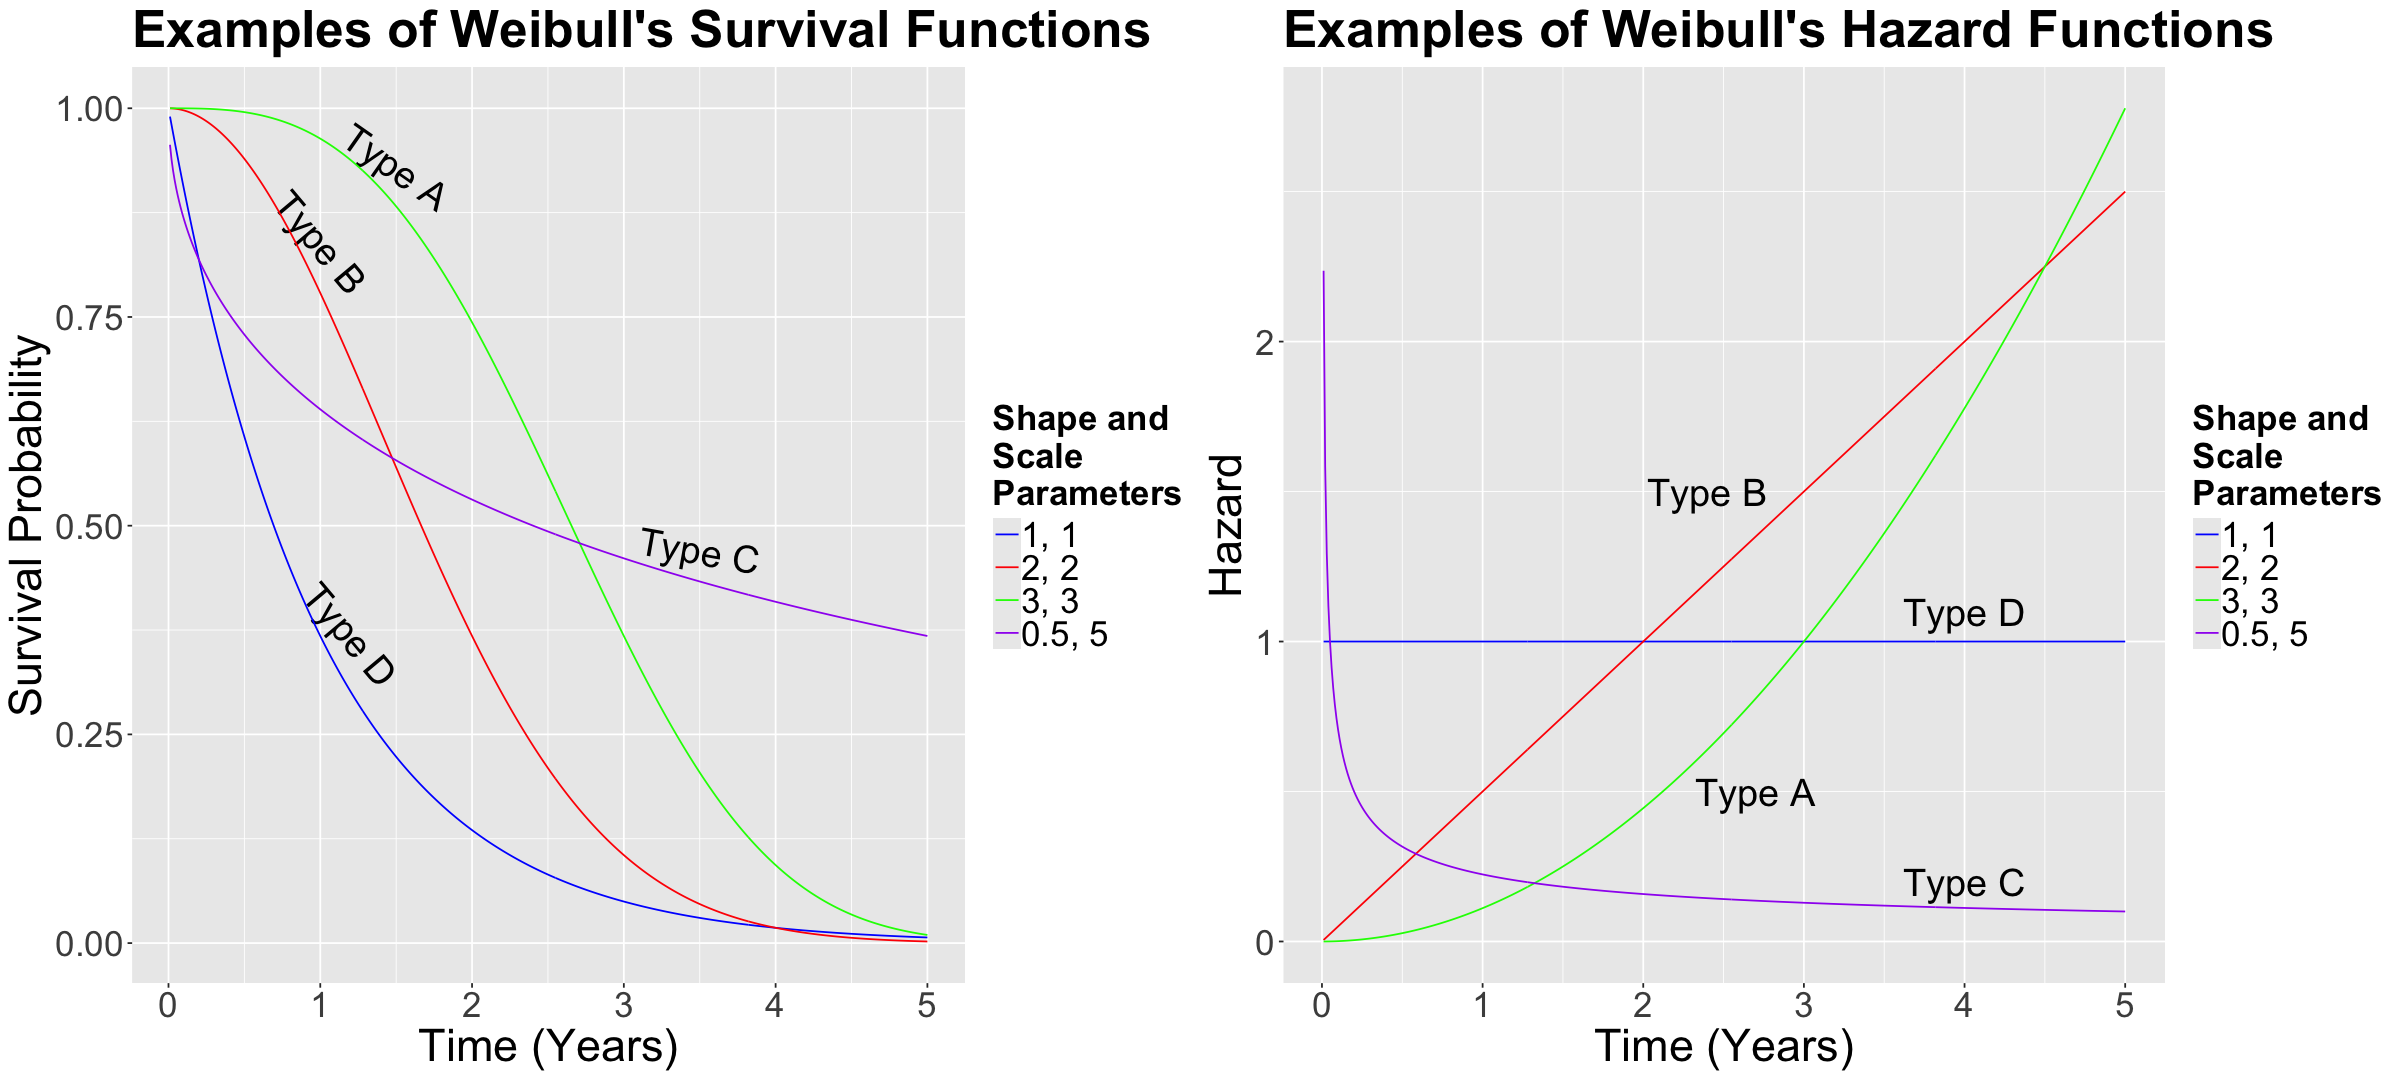

In [6]:
options(repr.plot.height = 9, repr.plot.width = 20)
plot_grid(weibull_plot + guides(color = guide_legend(title = "Shape and \nScale \nParameters")), 
  weibull_hazard, nrow = 1)

```{exercise}
:label: lecture5-q4

Suppose that these curves are the hazard functions of cancer patients for different types of cancer. Let us compare the *blue* (*Type D*) and *green* (*Type A*) curves.
```

```{important} 
Other heavy-tailed distributions can also be used to model the survival function, such as:

  - [Exponential](http://www.math.wm.edu/~leemis/chart/UDR/PDFs/Exponential.pdf).  
  - [Log-normal](http://www.math.wm.edu/~leemis/chart/UDR/PDFs/Lognormal.pdf).
  - [Generalized Gamma](http://www.math.wm.edu/~leemis/chart/UDR/PDFs/Generalizedgamma.pdf).
  - [Rayleigh](http://www.math.wm.edu/~leemis/chart/UDR/PDFs/Rayleigh.pdf).
  - [Pareto](http://www.math.wm.edu/~leemis/chart/UDR/PDFs/Pareto.pdf).
```

## 4. Estimating the Survival Function

We will not know the probability distribution to be used in our survival and hazard functions in practice. As Data Scientists, it is up to you to make modelling decisions before estimating the corresponding survival parameters of interest (in the case of a parametric approach such as a probability distribution). Moreover, there is also a quite popular non-parametric approach to be covered later on in this lecture.

```{important}
Statistically, recall that a parametric model has distributional assumptions on its components. Furthermore, Regression Analysis also includes the corresponding intercept and coefficients in the systematic component.
```

### 4.1. The Ovarian Dataset

For this section, we will use the dataset `ovarian` from the package `survival`.

```{admonition} The Ovarian Dataset
The `ovarian` dataset contains 26 survival records of a randomized trial that compares two treatments for ovarian cancer.
```

```{admonition} Definition of Randomized Trial
:class: tip
In statistical practice, we have a **randomized trial** when we run an experiment in which the subjects are randomized to either one of the $k$ treatments. The main purpose of these experiments is to infer **causation** on the effect of these treatments on a given response of interest.
```

We will use the following columns from `ovarian`:

- `futime`: The **continuous survival or censoring time** in days.
- `fustat`: A **binary factor** indicating if the patient died (`1` if true and `0` otherwise).
- `rx`: A **binary factor** indicating the treatment group (`1` or `2`). Thus, $k = 2$.

In [7]:
ovarian <- ovarian %>% select(futime, fustat, rx)
ovarian

,futime,fustat,rx
,<dbl>,<dbl>,<dbl>
1,59,1,1
2,115,1,1
3,156,1,1
⋮,⋮,⋮,⋮
24,353,1,2
25,365,1,2
26,377,0,2


```{admonition} Main Statistical Inquiries
We are interested in the following:

1. **Regardless of the cancer treatment used**, is it possible to estimate the overall survival function for this population of cancer patients?
2. Now, **in terms of the specific cancer treatments**, is there a statistical difference between both treatments? If so, can we quantify it? How would this be possible? Moreover, can we obtain the corresponding **estimated survival functions**?
```

### 4.2. The `Surv` Function

Usually, after our main statistical inquiries, we proceed with the exploratory data analysis (EDA). Nonetheless, inquiry (1) merges this step with the corresponding general modelling framework and estimation. **At the end of the day, we would plot an estimated survival function.**

Let us start using `R` to obtain this overall survival function. One of the key functions of the `survival` package is `Surv()`. `Surv()` will receive two parameters. The first one is **the survival or censoring time**, and the second one if **the recorded time was censored (`0`) or whether the actual event happened (`1`)**.

The plus signs mean the `futime` was censored (**we only know that the time is higher than that!**).

In [8]:
Surv(ovarian$futime, ovarian$fustat)

 [1]   59   115   156   421+  431   448+  464   475   477+  563   638   744+
[13]  769+  770+  803+  855+ 1040+ 1106+ 1129+ 1206+ 1227+  268   329   353 
[25]  365   377+

```{admonition} What would happen if we discard the censored observations?
This would be a serious mistake. In this case, we will probably underestimate the mean survival `time` because we are only considering the patients that already died **before the study ended**. 

Let us compute the mean survival time for those **non-censored** observations.
```

In [9]:
ovarian %>%
  filter(fustat == 1) %>%
  .[["futime"]] %>%
  mean() %>%
  round()

[1] 351

Now, let us compute the mean time using **all observations**. 

```{warning}
Nevertheless, note that including those censored observations does **NOT** mean this is the **correct estimation** of the population's survival time.
```

In [10]:

round(mean(ovarian$futime))

[1] 600

By looking at these two figures, it seems there are problems with ignoring censored data. **What should we do then?**

There are two options for estimating quantities by incorporating the **partial information contained in censored observations** in the form of an **estimated survival function** of the population of interest:

- **Non-parametric:** **If we do not make any distributional assumption**, the Kaplan-Meier (KM) method can be used to estimate the survival function. This option will implicate the following:

  - **RESTRICTED mean:** it can be estimated as the area under an estimate of the survival function.
  - [**Quantiles:**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/lectures/continuous-distributions.html) they can be estimated by inverting an estimate of the survival function.

- **Parametric:** If a distributional assumption is made, we can use **censored likelihood-based** methods to estimate the parameters of the chosen heavy-tailed PDF for the **observed survival times** (e.g., Weibull). Therefore, any quantity (**such as the theoretical mean or specific quantiles**) can be extracted from that chosen distribution (not necessarily through the survival function!).

````{admonition} Note

Let us consider a continuous and **positive (i.e., it goes from $0$ to $\infty$)** random variable 

$$Y = \text{Time until an event occurs measured in } t \text{ units},$$

whose CDF is $F_Y(t)$. We know that the survival function $S_Y(t)$ can be obtained as:

$$
F_Y(t) = 1 - S_Y(t).
$$

Furthermore, the PDF $f_Y(t)$ can be obtained as 

```{math}
\begin{align*}
f_Y(t) &= \frac{dF_Y(t)}{dt} \\
&= -\frac{dS_Y(t)}{dt}.
\end{align*}
```

Using the above equation, we can make the following **rearrangement**:

```{math}
\begin{align*}
f_Y(t) dt & = dF_Y(t) \\
&= -dS_Y(t).
\end{align*}
```

Now, let us show **mathematically** that the expected (or mean!) survival time to event, i.e. $\mathbb{E}(Y)$, is equal to the **area under the survival function $S_Y(t)$**:

```{math}
\begin{align*}
\mathbb{E}(Y) &= \int_{t = 0}^{t = \infty} t f_Y(t)dt \qquad \text{expected value definition} \\
&= \int_0^{\infty} - t dS_Y(t) \qquad \text{our above rearrangement} \\
&= -t S_Y(t)\Big|_0^{\infty} + \int_0^{\infty} S_Y(t) dt \qquad \text{integration by parts} \\
&= \underbrace{0}_{\lim_{t\to\infty} t S_Y(t) = 0} + \int_0^{\infty} S_Y(t) dt \\
&= \int_0^{\infty} S_Y(t) dt
\end{align*}
```

The above integral of $S_Y(t)$ from $0$ to $\infty$ represents the area under the survival function which is equal to the expected survival time to event, $\mathbb{E}(Y)$.


**Note this proof is out of the scope of this course.**
````

### 4.3. Non-Parametric Estimation and Inference of the Survival Function with Kaplan-Meier 

Non-parametric estimation is handy when we have a training dataset of survival times, but we have no idea how the survival function looks. Furthermore, we want to err on the side of caution **by no assuming any random variable distribution**.

KM is a non-parametric method to estimate the survival function. Since it is non-parametric, we do not need to make any distributional assumption on the survival function. This non-parametric estimated survival curve has the form of a **step function** computed with conditional probabilities.

```{attention}
This method is incredibly popular, and it is one of the most cited papers in Statistics (**over 65,000 citations!**). You can find the original 1958 paper [here](https://web.stanford.edu/~lutian/coursepdf/KMpaper.pdf).
```

Since the survival function fully characterizes the random variable, if we know the survival function, we can estimate different statistics such as the mean, quantiles, etc.

Let us estimate the survival function, obtain the mean survival time, and compare it with the two mean estimates we previously obtained: the **mean survival time for those non-censored observations** ($351$ days) and the **mean time of all observations** ($600$ days).

The Kaplan-Meier estimate of the survival function can be obtained with `survfit()` from the package `survival`. It expects a `formula`, but we are still working with the **null model** (i.e., **we consider all observations by not subsetting them by `rx` in the dataset `ovarian`**).

In [11]:
fit_km <- survfit(
   formula = Surv(futime, fustat) ~ 1,
   data = ovarian
  )
fit_km

Call: survfit(formula = Surv(futime, fustat) ~ 1, data = ovarian)

      n events median 0.95LCL 0.95UCL
[1,] 26     12    638     464      NA

The general output from `survfit()` indicates the total data points ($n = 26$), $12$ events of interest (i.e., the subjects who did not survive), the `median` survival time and its corresponding 95% confidence interval (CI).

```{important}
In this case, note that there is no upper bound since 50% of the sampled subjects were still alive by the end of the study (check the last proportion of subjects still alive in the column `estimate` below).
```

To obtain the survival function, we can use `summary()`, or even better, `tidy()`.

In [12]:
options(repr.matrix.max.rows = 20)

tidy(fit_km) %>%
  mutate_if(is.numeric, round, 2)

time,n.risk,n.event,n.censor,estimate,std.error,conf.high,conf.low
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
59,26,1,0,0.96,0.04,1.00,0.89
115,25,1,0,0.92,0.06,1.00,0.83
156,24,1,0,0.88,0.07,1.00,0.77
268,23,1,0,0.85,0.08,1.00,0.72
329,22,1,0,0.81,0.10,0.97,0.67
353,21,1,0,0.77,0.11,0.95,0.62
365,20,1,0,0.73,0.12,0.92,0.58
377,19,0,1,0.73,0.12,0.92,0.58
421,18,0,1,0.73,0.12,0.92,0.58


```{important}
The `tidy()` output provides eight metrics as columns from our training data. Part of these metrics refers to inferential tools such as 95% CIs and the standard errors to construct them. Recall we are aiming to infer the survival function of our population. **The above CI metrics rely on a large enough sample size $n$ (i.e., they are asymptotic).**
```

Suppose $n$ is the initial number of subjects in our study. Hence, let us start with the computations from left to right:

- `time`: The column refers to a specific `time` point throughout the survival study at which we confirm the survival status of all the subjects who are still alive or non-censored. Mathematically, we call it $t$. So, for instance, for the ninth row in the tidy output, we have that $t = 421$ days.
- `n.risk`: Number of subjects at risk at time $t$ **before we record the number of subjects who experienced the event of interest or were censored**. Mathematically, we call it $n_t$. For the ninth row, we have that $n_t = 18$.
- `n.event`: Number of subjects who experienced the event of interest at time $t$. Mathematically, we call it $d_t$. On the ninth row, we have that $d_t = 0$ (i.e., nobody died at that time point).
- `n.censor`: Number of **censored subjects** at time $t$. Mathematically, we call it $c_t$. For the ninth row, we have that $c_t = 1$ (i.e., we stopped following up one subject who was still alive at that time point).
- `estimate`: The proportion of subjects at time $t$ still alive in our study. Mathematically, we call it $\hat{S}(t)$, [**and is based on the conditional probability rule**](https://ubc-mds.github.io/DSCI_551_stat-prob-dsci/lectures/joint-probability-part-i.html#). We compute it as:

$$
\hat{S}(t) = \hat{S}(t - 1) \times \frac{(n_t - d_t)}{n_t}.
$$

- `std.error`: The standard error of the estimate $\hat{S}(t)$. It is computed as follows:

$$
\text{se}\left[\hat{S}(t)\right] = \hat{S}(t) \sqrt{\sum_{i \leq t} \frac{d_i}{n_i (n_i - d_i)}}.
$$

- `conf.high` and `conf.low`: These columns correspond to the upper and lower bounds of the $(1 -\alpha) \times 100\%$ CI for $\hat{S}(t)$. This CI is computed as:

$$\exp\left\{ \log \left[ \hat{S}(t) \right] \pm  z_{\alpha/2} \cdot \frac{\text{se}\left[\hat{S}(t)\right]}{\hat{S}(t)} \right\}.$$

```{attention}
$z_{\alpha/2}$ is the **upper** $\alpha/2$ quantile of the **Standard Normal distribution** with a significance level $\alpha$.
```

To plot `fit_km` we can use `autoplot()` from package `ggfortify` for a `ggplot2` style. We can add other layers to the resulting `ggplot2` object. Notice the “**notches**” where there is a censored observation.

In [13]:
fit_km_plot <- autoplot(fit_km) +
    theme_bw() +
    ylab("Survival Probability") +
    xlab("Survival Time (days)") +
    ylim(0, 1) +
  theme(
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27)
  )

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


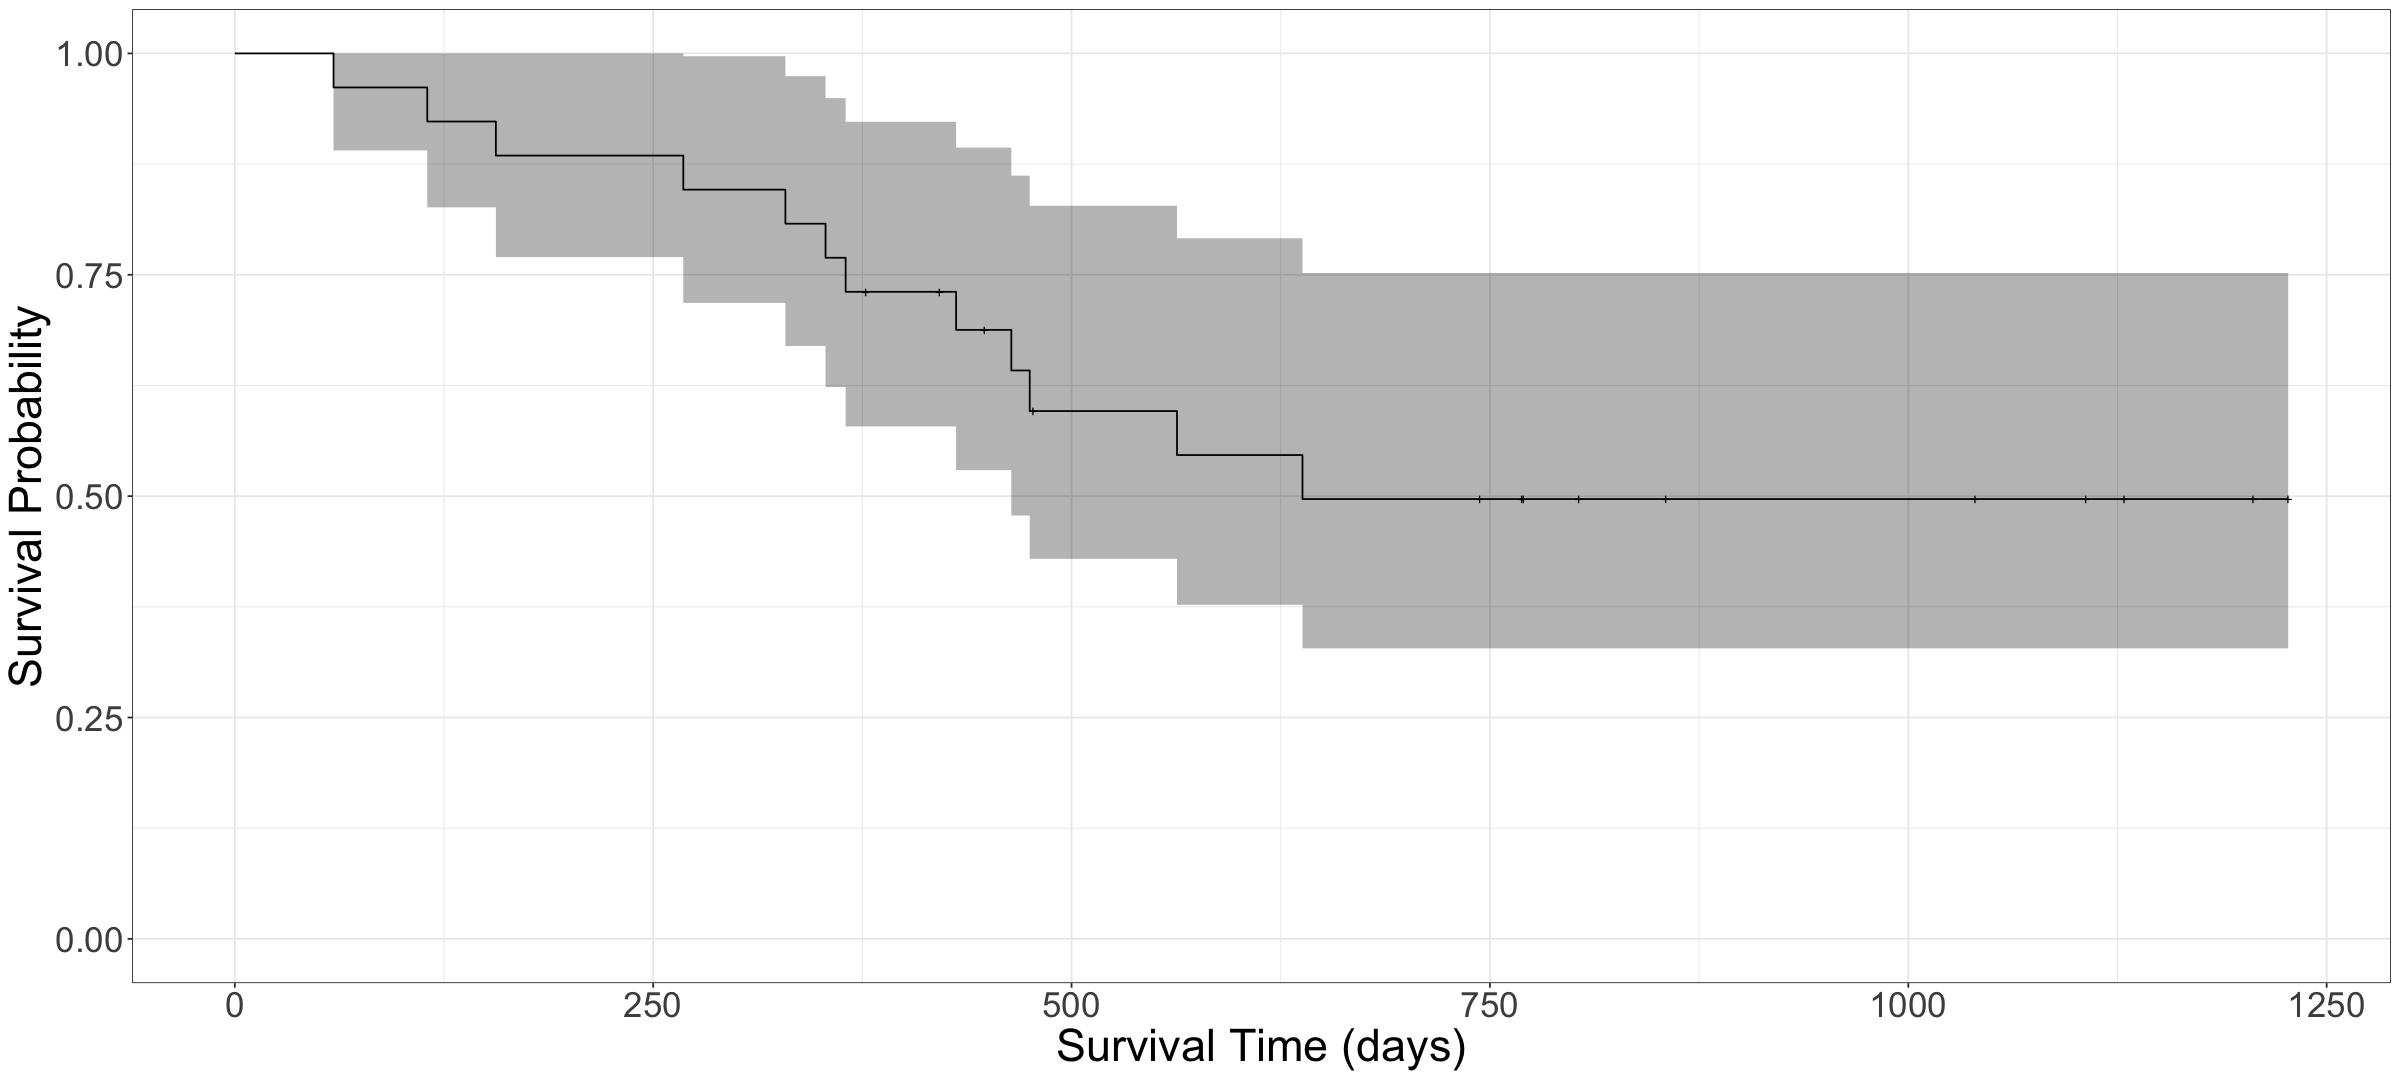

In [14]:
fit_km_plot

Now that we have our **estimated survival function**, we could calculate the mean survival time and compare it with our previous "raw" mean estimates: the **mean survival time for those non-censored observations** ($351$ days) and the **mean time of all observations** ($600$ days).

In [15]:
glance(fit_km) %>%
  mutate_if(is.numeric, round, 3)

records,n.max,n.start,events,rmean,rmean.std.error,median,conf.low,conf.high,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26,26,26,12,793.999,91.518,638,464,NA,26


The `r` in `rmean` means **restricted**.

```{admonition} Why restricted?
- The Kaplan-Meier estimate of the survival function does not always drop to zero (when the largest observation is censored).
- A common "fix" is to force the survival function to drop to zero at the largest observation. The mean estimate that results is called the **restricted mean**.
```

We can find the **median survival time** on the printout of `glance(fit_km)`. However, in general, we can use the `quantile()` S3 generic function from the package `survival`.

In [16]:
quantile(fit_km,
  probs = 0.5,
  conf.int = FALSE
)

50 
638

### 4.4. Parametric Estimation and Inference of the Survival Function with a Distributional Assumption

As we discussed in the Weibull example above, if we know the distribution family of the survival time $Y$ we can get its survival function

$$S_Y(t) = 1 - F_Y(t).$$

Nonetheless, just knowing the family is not enough. **What else do we need?**

- We need the corresponding **parameters of the distribution**.
- If we assume that the data follows a specific distribution, say Weibull, all there is left for us to do is estimate the parameters of the Weibull. Nevertheless, we need to consider the censored data.
- We can do this using the `survreg()` function.

#### The `survreg()` function

Now, it is time to work with the `survreg()` function. This function corresponds to a parametric regression for a  Survival Model.

Let us fit the Log-normal distribution under one survival **null** regression model using dataset `ovarian`.

```{important}
These parametric models are also generalized linear models (GLMs). There is a link function in the form of a hazard function that relates the distributional parameters with a given set regression parameters and regressors. The estimation of these parameters is done by maximizing a particular likelihood function. This function incorporates the observed information of the censored and uncensored data points and the survival status.

**This lecture will only encompass null models, but `survreg()` can also incorporate regressors on the right-hand side of the `formula` argument.** Moreover, it also provides the corresponding inferential output to assess the statistical significance of these regressors.
```

In [17]:
model_lognormal <- survreg(
  formula = Surv(futime, fustat) ~ 1,
  dist = "lognormal", data = ovarian
)

Now, let us compute the **in-sample fitted values** for both models. These fitted lines will appear on top of our previous estimated KM survival function.

In [18]:
surv_fitted <- tibble(
  x = seq(0, max(ovarian$futime), 0.1),
  Log_Normal = plnorm(x,
    meanlog = model_lognormal$coefficients[1],
    sdlog = model_lognormal$scale, lower.tail = FALSE
  ))

surv_fitted <- surv_fitted %>%
  pivot_longer(cols = c("Log_Normal"), names_to = "Model", values_to = "Survival")

fit_km_and_param_plot <- fit_km_plot +
  geom_line(aes(x, Survival, color = Model), data = surv_fitted, linewidth = 1.5) +
  ylim(0, 1) +
  theme(
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 21, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 21, face = "bold")
  ) +
  ylab("Survival Probability") +
  xlab("Survival Time (days)")

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


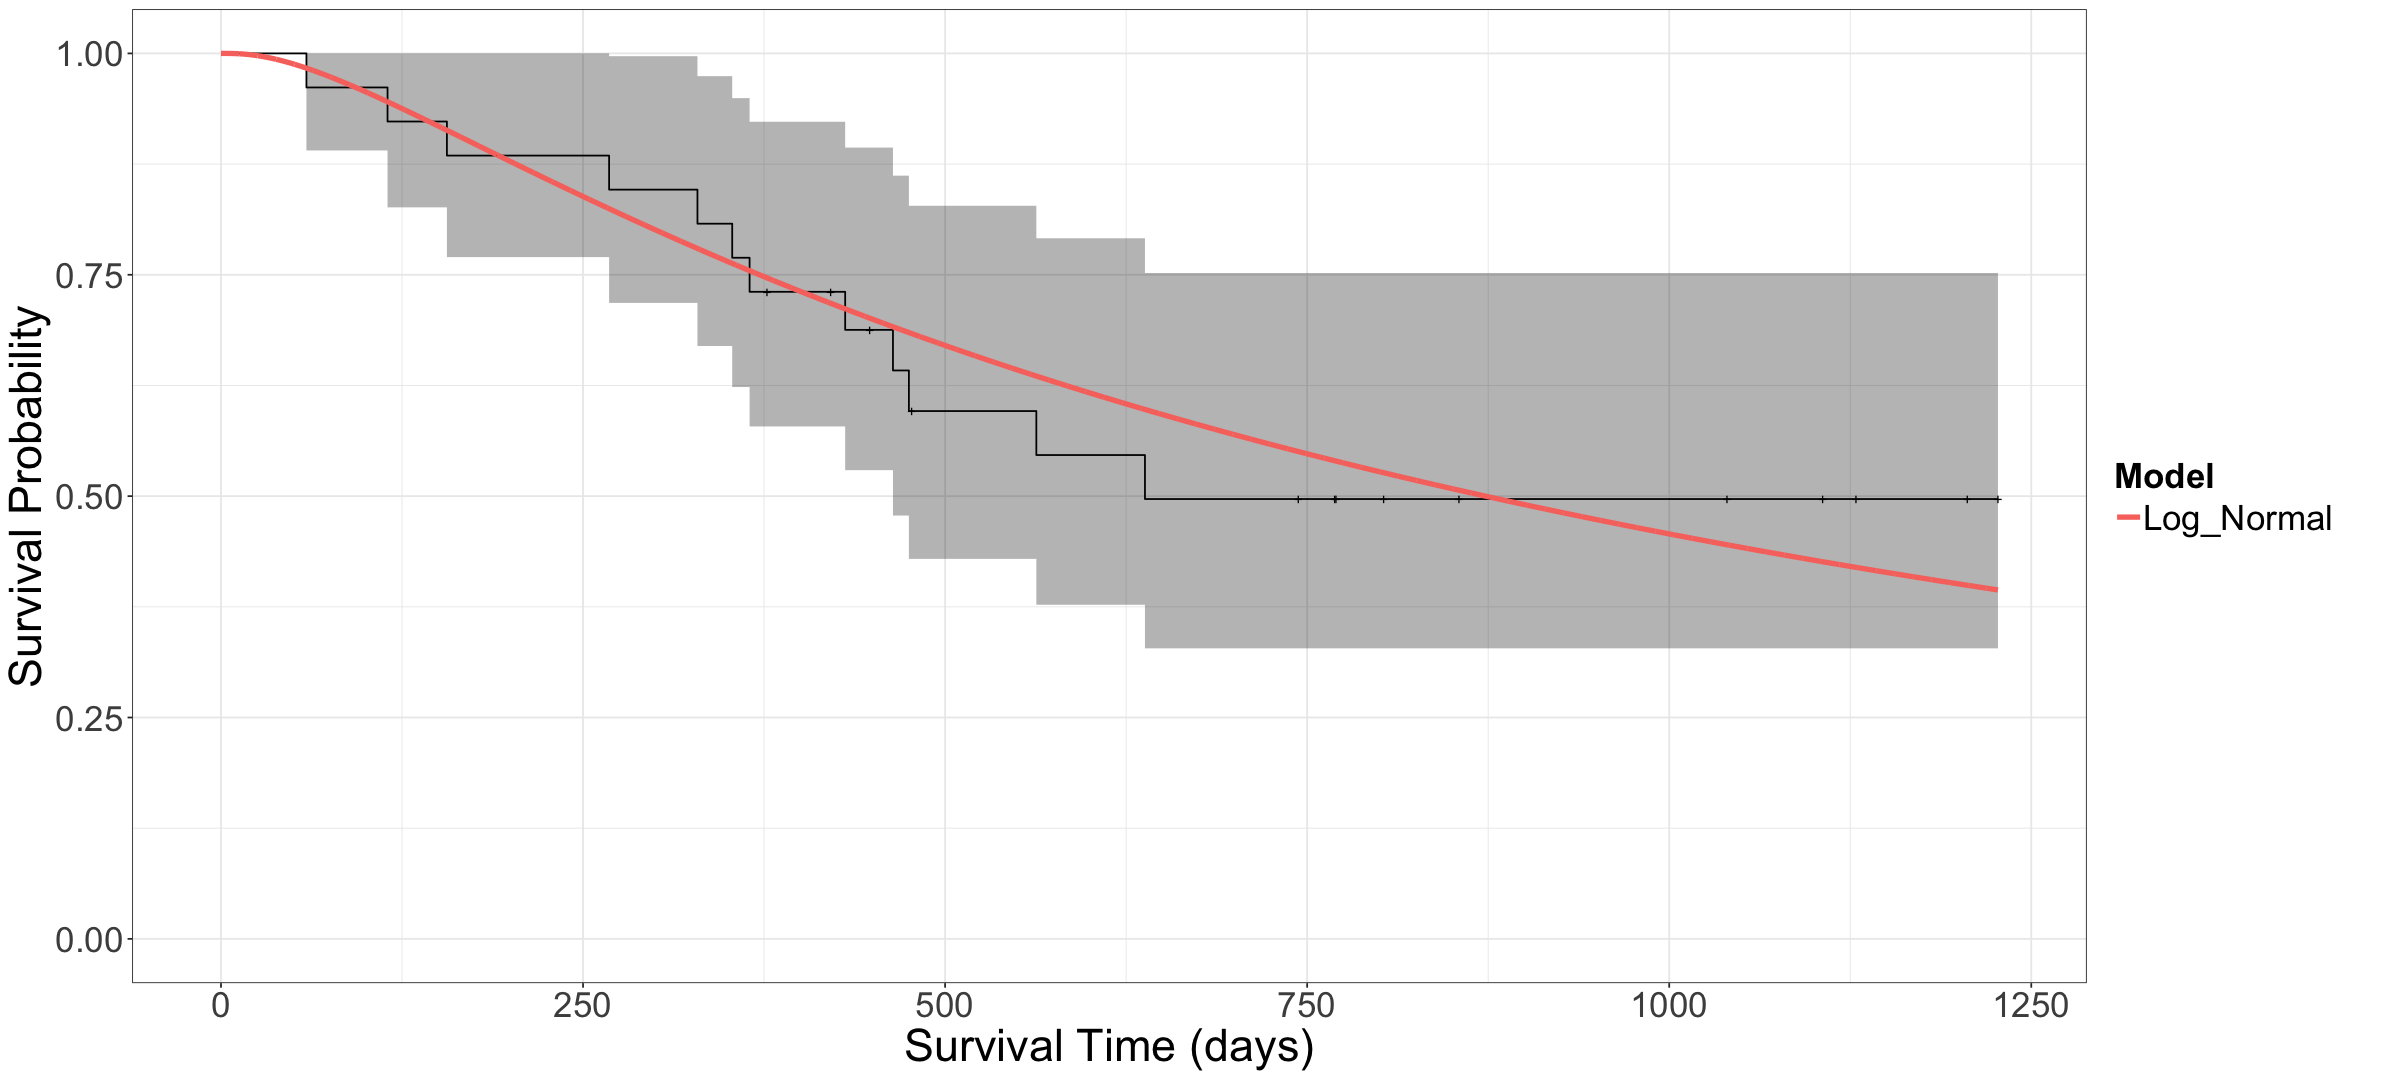

In [19]:
fit_km_and_param_plot

**Alternatively**, to get the in-sample values, we can use the function `predict()` with `model_lognormal` as follows:

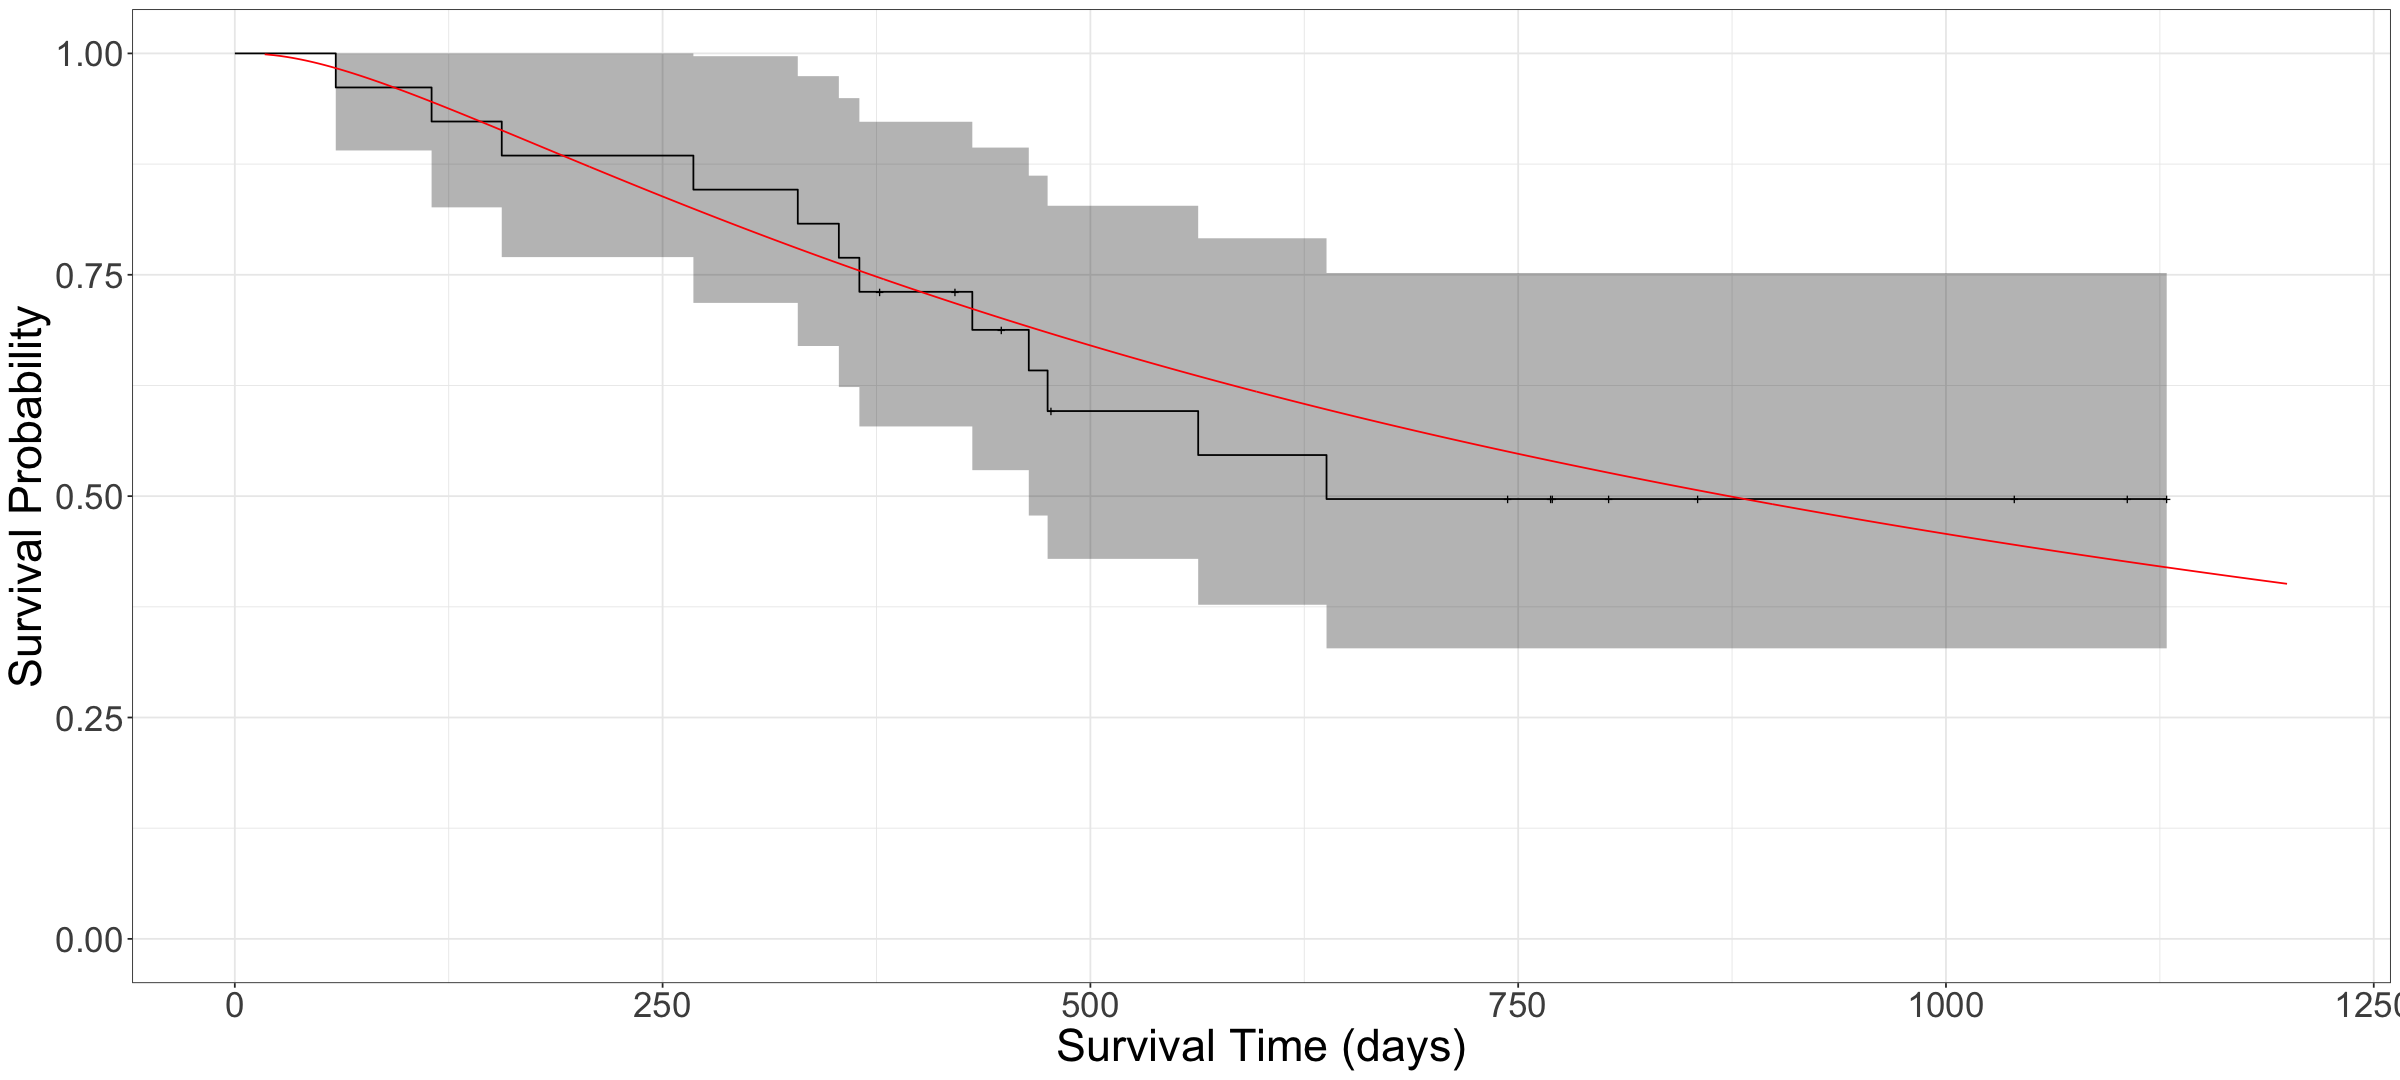

In [20]:
est_survival <- tibble(
  surv = seq(0.999, 0.001, -0.001),
  time_lognormal = predict(model_lognormal, newdata = tibble(x = 1), type = "quantile", p = 1 - surv)
)

fit_km_and_param_plot_alt <- fit_km_plot  +
  geom_line(aes(time_lognormal, surv), data = est_survival, color = "red") +
  xlim(0, 1200) +
  theme(
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 21, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 21, face = "bold")
  )

suppressWarnings(suppressMessages(print(fit_km_and_param_plot_alt)))

```{exercise}
:label: lecture5-q5

What is the advantage or disadvantage of making a distributional assumption? 
```

## 5. Cox Proportional Hazards Model

We have already estimated the population survival function for this class of cancer using a non-parametric and parametric approach. Nevertheless, this does not address our inquiry (2). Of course, we could expand our previous Survival Analysis to address it. Still, we will take an alternative approach in the form of a widely popular **semiparametric** regression model called **Cox Proportional Hazards** (namely, **Cox regression**).

```{important}
**In Statistics**, we call a regression model semiparametric when we only define the systematic component (i.e., regressors and regression estimates). Yet, we **do not assume any specific distribution** for our response of interest.
```

### 5.1. Exploratory Data Analysis

Before getting into the general modelling framework of this regression model, performing an EDA to compare the survival times by censoring status and treatment using side-by-side boxplots is necessary.

In [21]:
ovarian <- ovarian %>% mutate(rx = as_factor(rx))

side_by_side_boxplots_ovarian <- ovarian %>%
  mutate(censor = if_else(fustat == 1, "Died", "Ongoing")) %>%
  ggplot(aes(rx, futime)) +
  geom_boxplot(aes(colour = censor)) +
  theme_bw() +
  labs(
    x = "Treatment",
    y = "Survival Time (Days)"
  ) +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27),
    legend.text = element_text(size = 21, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 21, face = "bold")
  )

Our EDA gives us **descriptive evidence** to state that the survival times for treatment `1` might be slightly higher than the ones for treatment `2` (`Ongoing` status in `censor`). However, some considerable overlap still needs to be addressed with proper statistical inference via regression analysis.

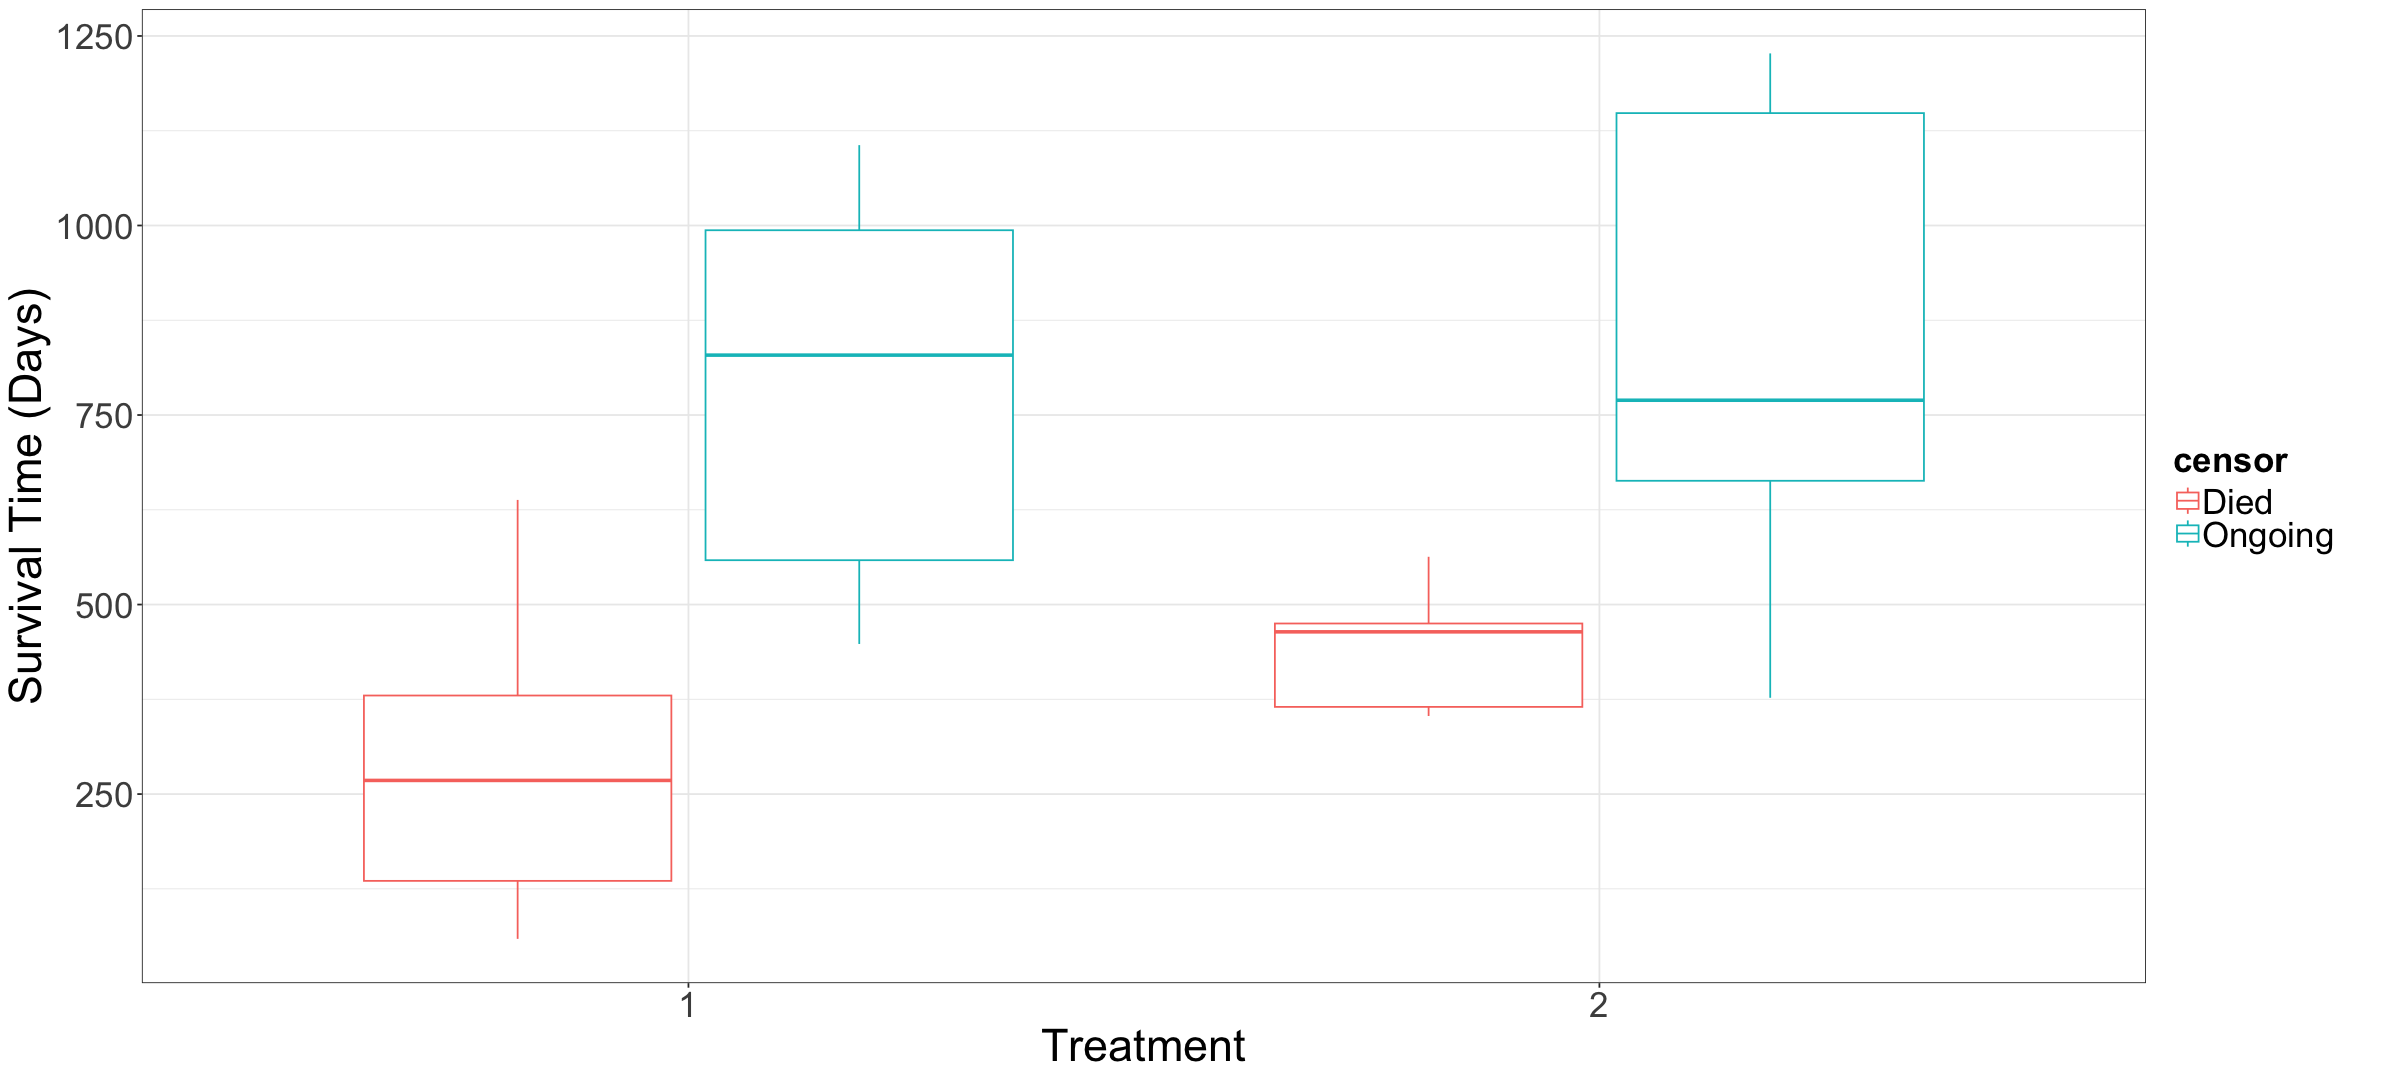

In [22]:
side_by_side_boxplots_ovarian

### 5.2. Data Modelling Framework

The Cox Proportional Hazards model is a commonly used survival model that allows us to interpret how regressors influence a censored response.

Using a training set of size $n$, the idea is to model the **hazard function** $\lambda_i(t)$ directly for the $i$th observation ($i = 1, \dots, n$) subject to $k$ regressors $X_{i,j}$ ($j = 1, \dots, k$):

$$\lambda_i \left( t | X_{i,1}, \dots, X_{i,k} \right) = \lambda_0(t) \exp\left(\sum_{j = 1}^k \beta_j X_{i,j}\right).$$


```{important}
This model has certain particularities, which will be highlighted below:

- We model the $i$th individual hazard function $\lambda_i \left( t | X_{i,1}, \dots, X_{i,k} \right)$ along with a baseline hazard $\lambda_0(t)$, which is equal for all the $n$ observations, multiplied by $\exp\left(\sum_{j = 1}^k \beta_j X_{i,j}\right)$.
- The model does not have an intercept $\beta_0$. Nevertheless, the baseline hazard $\lambda_0(t)$ acts as the intercept in this survival framework.
- The baseline hazard $\lambda_0(t)$ is the reference **for all subjects** when all covariates are equal to zero. Note this baseline hazard depends on time $t$ **unlike the regressors $X_{i,j}$**. Cox regression does not assume any distribution on this baseline hazard, which is the non-parametric part of the model.
- The parametric part of the model is reflected in $\exp\left(\sum_{j = 1}^k \beta_j X_{i,j}\right)$.
- Therefore, given the combinations of both situations, Cox regression is overall defined as semiparametric.
```

```{admonition} Note
:class: warning
A more complex Cox regression model would also put the regressors in function of time $t$. However, this framework is **out of the scope of this lecture**.
```

To exemplify the **proportional hazards** assumption, let us consider a simple Cox regression model with a continuous regressor $X_{i, 1}$. Moreover, assume these two subjects $i = 1, 2$ have the following regressor values: 

$$X_{2, 1} = X_{1, 1} + 1 \qquad \text{Subject 2's regressor value is one unit larger}.$$

Their responses can be modelled as:

```{math}
\begin{align*}
\lambda_1 \left( t | X_{1,1} \right) = \lambda_0(t)\exp\left( \beta_1 X_{1,1} \right) \qquad \text{Subject 1}
\end{align*}
```
```{math}
\begin{align*}
\lambda_2 \left( t | X_{2,1} \right) &= \lambda_0(t)\exp\left( \beta_1 X_{2,1} \right) \\
&= \lambda_0(t)\exp\left[ \beta_1 (X_{1,1} + 1) \right] \\
&= \lambda_0(t)\exp\left( \beta_1 X_{1,1} \right) \exp \left( \beta_1 \right) \qquad \text{Subject 2}
\end{align*}
```

Then, the hazard ratio comes into play as:

$$
\frac{\lambda_2 \left( t | X_{2,1} \right)}{\lambda_1 \left( t | X_{1,1} \right)} = \frac{\lambda_0(t)\exp\left( \beta_1 X_{1,1} \right) \exp \left( \beta_1 \right)}{\lambda_0(t)\exp\left( \beta_1 X_{1,1} \right)} = \exp\left( \beta_1 \right) \quad \Rightarrow \quad \lambda_2(t) = \lambda_1(t)\exp\left( \beta_1 \right)
$$

```{important}
**In plain words and generally**, the proportional hazards assumption assumes that the hazard for any subject is proportional to the hazard of any other subject **via the exponentiated regression coefficients**.
```

### 5.3. Estimation

Parameter estimation in Cox regression is done through another special maximum likelihood technique using a **partial likelihood**. A partial likelihood is a specific class of **quasi-likelihood**, which does not require assuming any specific PDF for the continuous survival times $Y_i$ (thus, the baseline hazard is not required to take any distributional form).

However, we use the parametric part 

$$\exp\left(\sum_{j = 1}^k \beta_j X_{i,j}\right)$$

to perform our corresponding estimation.

To fit a Cox Proportional Hazards model using `R`, we can use `coxph()` from the `survival` package. The `formula` argument will contain `rx` (**binary factor** indicating the treatment group, `1` or `2`) to address our specific inquiry (2):

> Now, **in terms of the specific cancer treatments**, is there a statistical difference between both treatments? If so, can we quantify it? How would this be possible? Moreover, can we obtain the corresponding **estimated survival functions**?

In [23]:
fit_ph <- coxph(
  formula = Surv(futime, fustat) ~ rx,
  data = ovarian
)

### 5.4. Inference

We can determine **whether a regressor is statistically associated with the response's hazard function** through **hypothesis testing** for $\beta_j$. We will need the estimated regression coefficient $\hat{\beta}_j$ and its **standard error**, $\mbox{se}(\hat{\beta}_j)$. 

You can test the below hypotheses via the **Wald statistic** $z _j= \frac{\hat{\beta}_j}{\mbox{se}(\hat{\beta}_j)}$:

```{math}
\begin{align*}
H_0: \beta_j &= 0 \\
H_a: \beta_j &\neq 0.        
\end{align*}
```

Given a large enough training size $n$, $z_j$ has an **approximately Standard Normal distribution** under $H_0$.

`R` provides the corresponding **$p$-value** for each $\beta_j$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. Hence, a small enough $p$-value (less than the significance level $\alpha$) indicates that the data provides evidence in favour of **association** (**or causation in the case of an experimental study!**) between the hazard function and the $j$th regressor. Furthermore, given a specified level of confidence, we can construct approximate $(1 - \alpha) \times 100\%$ CIs for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm z_{\alpha/2}\mbox{se}(\hat{\beta}_j),
$$

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the **Standard Normal distribution**.

Modelling output can be obtained via `tidy()`:

In [24]:
tidy(fit_ph, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rx2,-0.596,0.587,-1.016,0.31,-1.747,0.554


Our sample gives us evidence to fail to reject $H_0$ ($p\text{-value} > .05$). So, we can already see that the difference between treatments (`rx)` is not statistically significant (under a $\alpha = 0.05$ level) for the response's hazard function.

### 5.5. Coefficient Interpretation

The hazard function is useful to model due to its flexibility and interpretability. Unfortunately, this example does not contain a continuous regressor to make the corresponding coefficient interpretation (we will address this matter in our warmup exercise in `lab3`). Nonetheless, in general, note the following:

> The coefficient $\beta_j$ on the continuous $j$th regressor $X_{i,j}$ has the following interpretation: **an increase in the regressor by one unit is associated with an increase in hazard (at any time) by $\exp(\beta_j)$ times (i.e., the effect is multiplicative)**.

Now, the interpretation for the regression coefficient in a categorical regressor is **the increase (at any time) by $\exp(\beta_j)$ times in hazard from the baseline category to another given category**.

In [25]:
tidy(fit_ph, exponentiate = TRUE, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rx2,0.551,0.587,-1.016,0.31,0.174,1.74


In this example, **if the regression coefficient were significant**, we would interpret the hazard function under treatment `2` to be $\exp(-0.596) = 0.551$ times as much as the hazard function under treatment `1`.

```{attention}
**Alternatively**, we would interpret the hazard function under treatment `1` as $1/0.551 = 1.81$ times as much as the hazard function under treatment `2`. **In plain words, for this alternative interpretation, treatment `2` would increase the survival times compared to treatment `1` if there were a statistically significant difference.**
```

### 5.6. Prediction

Before getting into the formulas for prediction via Cox regression, let us introduce another important function.

```{admonition} Definition of Cumulative Hazard Function
:class: tip

The cumulative hazard function $\Lambda(t)$ depict the accumulated amount of hazard up to time $t$ as follows:

$$
\Lambda(t) = \int_0^{t} \lambda(u)du.
$$

Furthermore, the cumulative hazard function $\Lambda(t)$ and survival function $S_Y(t)$ are mathematically related as follows:

$$\Lambda(t) = -\log S_Y(t).$$
```

Even though Cox regression models the hazard function $\lambda_i(t)$, it is possible to obtain **a given estimated survival function** via the following equation:

$$S\left( t | X_1, \dots X_k \right) = S_0(t)^{\exp\left(\sum_{j = 1}^k \beta_j X_{i,j}\right)},$$

where 

$$S_0(t) = \exp \left[ - \Lambda_0(t) \right]$$

is the **baseline survival function**. 

Note that $\Lambda_0(t)$ is the cumulative baseline hazard function:

$$\Lambda_0(t) = \int_0^{t} \lambda_0(u)du.$$

We use the baseline cumulative hazard $\Lambda_0(t)$ to obtain $S_0(t)$.

Our `coxph()` model object will provide the corresponding estimates $\hat{\Lambda}_0(t), \hat{\beta}_1, \dots, \hat{\beta}_k$ to obtain the estimated survival functions $\hat{S}_0(t)$ and $\hat{S} \left( t | X_1, \dots X_k \right)$. Then, via `survfit()` along with `ggsurvplot()` from package `survminer`, we can obtain the predicted survival functions for treatments `1` and `2` as follows:

```{admonition} Note
:class: warning
Further mathematical details about Cox regression estimation for $\hat{\Lambda}_0(t), \hat{\beta}_1, \dots, \hat{\beta}_k$ are provided by [**Kalbfleisch and Prentice (2002)**](https://gw2jh3xr2c.search.serialssolutions.com/?sid=sersol&SS_jc=TC0000487630&title=The%20statistical%20analysis%20of%20failure%20time%20data) in Chapter 4.
```

In [26]:
survfit_object <- survfit(fit_ph, data.frame(rx = levels(ovarian$rx)))

cox_ph_surv_plots_rx <- ggsurvplot(survfit_object,
  data = data.frame(rx = levels(ovarian$rx)), ylab = "Survival Probability",
  xlab = "Time (days)", font.x = c(27, "bold"), font.y = c(27, "bold"),
  font.tickslab = c(27, "plain"), font.title = c(31, "bold"), font.legend = c(21, "bold"),
  legend = "bottom", ggtheme = theme_survminer()
) +
  labs(colour = "Treatment", fill = "Treatment") +
  ggtitle("Estimated Survival Curves by Ovarian Cancer Treatment")  

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
ℹ Please use `gather()` instead.
ℹ The deprecated feature was likely used in the survminer package.
  Please report the issue at <https://github.com/kassambara/survminer/issues>.”


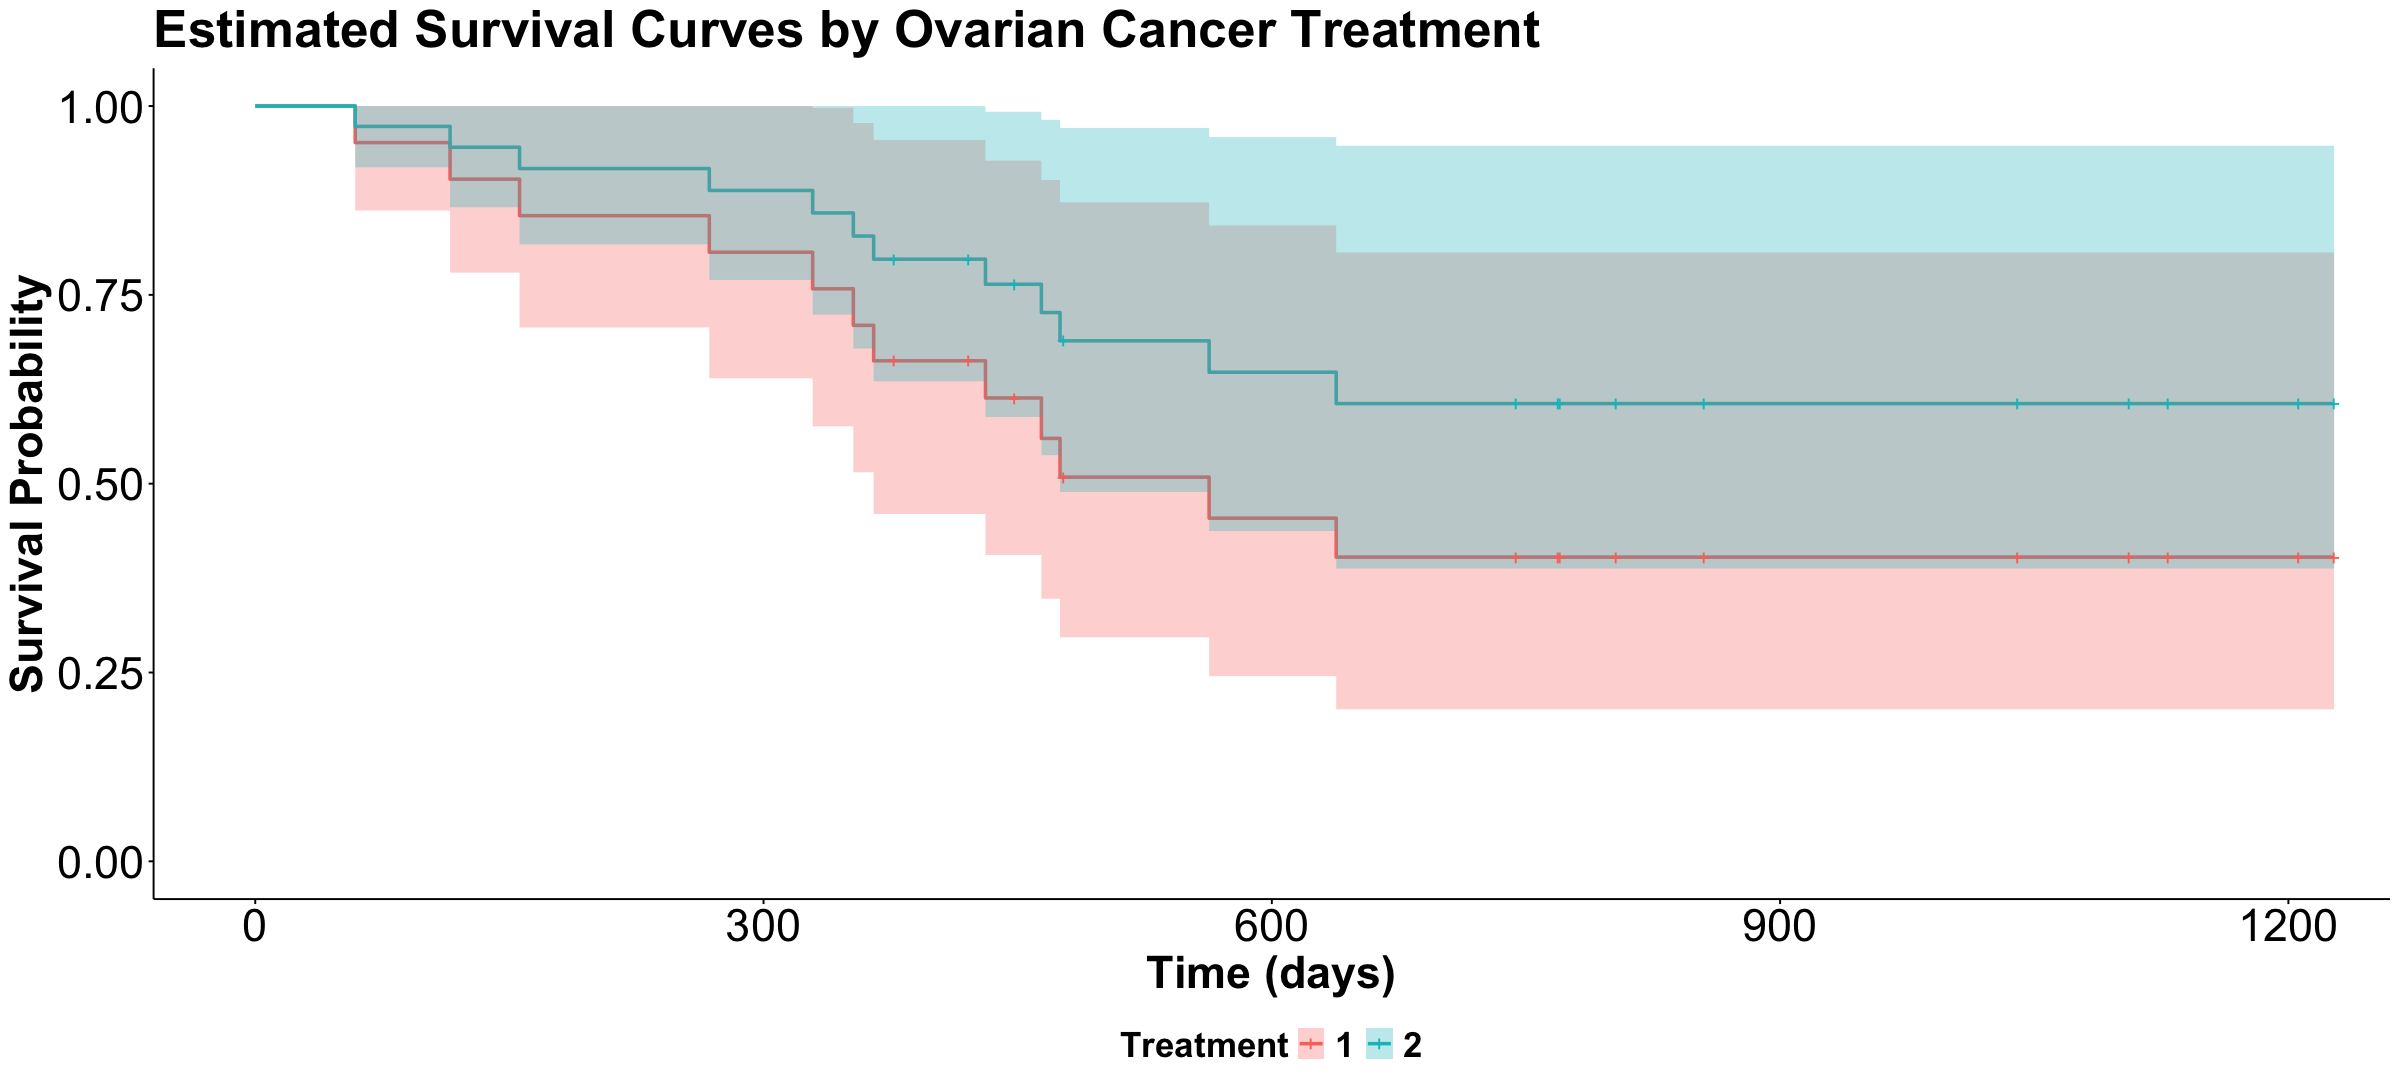

In [27]:
cox_ph_surv_plots_rx

Note that even though treatment `2` has an estimated survival function that depicts more chances to survive; once we plot the corresponding 95% CIs by treatment, **they overlap, which indicates there is no statistical difference between both treatments**.

## 6. Wrapping Up on Survival Analysis

- Survival Analysis allows modelling data when censorship is present.
- A key characteristic of this field is how we treat the randomness associated with those censored observations.
- Fundamental concepts involve the use of probability statements on survival times.
- We can extend the regression paradigm to survival times using parametric and non-parametric approaches.